### Konfiguracja

In [2]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [3]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]

    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# Rozwiązanie 

#### Autorzy: Zuzanna Borek, Piotr Kica

#### Przygotowanie

In [4]:
# Wymagana biblioteka do zainstalowania
!python -m pip install kdtree

You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [5]:
# Aby działała wizualizacja
%matplotlib notebook

In [6]:
# Potrzebne biblioteki 
import math
import kdtree
import queue

### Potrzebne klasy do reprezentacji obiektów

#### Punkt 

In [7]:
class Point:
    # Inicjalizacja punktu
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    # Funkcja do sprawdzenia identyczności dwóch punktów 
    def __eq__(self, other):
        return (self.x, self.y) == (other.x, other.y)
    
    # Funkcja do porównywania dwóch punktów
    def __lt__(self, other):
        return (self.x, self.y) < (other.x, other.y)
    
    # Funkcja do reprezentowania punktu jako napis
    def __repr__(self):
        return "("+str(self.x)+", "+str(self.y)+")"
    
    def __hash__(self):
        return hash(self.x, self.y)

#### Linia

In [8]:
class Line:
    # Inicjalizacja linii
    def __init__(self, p1, p2):
        self.point_1 = p1
        self.point_2 = p2
        if(self.point_1 > self.point_2):
            self.point_1, self.point_2 = self.point_2, self.point_1
    
    # Funkcja do sprawdzenia identyczności dwóch linii
    def __eq__(self, other):
        return self.to_tuple() == other.to_tuple()

    # Funkcja do reprezentowania linii w postaci krotki punktów
    def to_tuple(self):
        return ((self.point_1.x, self.point_1.y), (self.point_2.x, self.point_2.y))
    
    def __hash__(self):
        return hash(self.to_tuple())

#### Trójkąt 

In [9]:
class Triangle:
    # Inicjalizacja trójkąta i obliczenie jego okręgu opisanego, przypisanie własności
    def __init__(self, p1, p2, p3):
        self.valid, x0, y0, r = self._circle_on_three_points(p1,p2,p3)
        self.points = [p1, p2, p3]
        self.lines = [Line(p1,p2),Line(p2,p3),Line(p3,p1)]
        self.circle_radius = r 
        self.circle_center = Point(x0,y0)
    
    # Funkcja do wyliczania środka i promienia okręgu opisanego
    def _circle_on_three_points(self, a, b, c):
        d = 2 * (a.x * (b.y - c.y) + b.x * (c.y - a.y) + c.x * (a.y - b.y))
        if (d==0):
            return False, (0,0),(0,0),0
        x0 = ((a.x * a.x + a.y * a.y) * (b.y - c.y) + (b.x * b.x + b.y * b.y) * (c.y - a.y)
              + (c.x * c.x + c.y * c.y) * (a.y - b.y)) / d
        y0 = ((a.x * a.x + a.y * a.y) * (c.x - b.x) + (b.x * b.x + b.y * b.y) * (a.x - c.x)
              + (c.x * c.x + c.y * c.y) * (b.x - a.x)) / d
        r = math.sqrt((a.x-x0) ** 2 + (a.y-y0) ** 2)
        return True, round(x0,8), round(y0,8), round(r, 8)
        
    # Funkcja do weryfikacji czy punkt należy do środka okręgu
    def in_circle(self, point):
        return math.sqrt((point.x-self.circle_center.x)**2 + (point.y-self.circle_center.y)**2) < self.circle_radius
    
    # Funkcja do reprezentowania trójkąta w postaci krotki z liniami
    def to_tuple(self):
        return tuple(line.to_tuple() for line in self.lines)

    def __hash__(self):
        p1 = (self.points[0].x,self.points[0].y)
        p2 = (self.points[1].x,self.points[1].y)
        p3 = (self.points[2].x,self.points[2].y)
        return hash((p1, p2, p3))

### Klasa do reprezentacji triangulacji i poszukiwania sąsiadów na potrzeby algorytmu

In [10]:
class TriangleDict:
    def __init__(self):
        # Słownik do odwzorowywania środka okręgu opisanego na jego trójkąt
        self.center_to_triangle_dict = dict()
        # Słownik do przechowywania sąsiadów danego trójkąta
        self.triangle_dict = dict()
        # Słownik do odwzorowywania linii na trójkąty którego jest częścią
        self.lines_dict = dict()
        # Kd-drzewo do znajdywania najbliższego okręgu opisanego dla danego punktu
        self.kdtree = kdtree.create(dimensions=2)
    
    # Funkcja do zwracania sąsiadów danego trójkata
    def get_neighbours(self, triangle):
        if(triangle not in self.triangle_dict):
             return []
        return self.triangle_dict[triangle]
    
    # Funkcja do zwracania trójkąta którego okrąg opisany jest najbliżej punktu
    def get_first_triangle(self, point):
        triangle_center = self.kdtree.search_nn((point.x, point.y))[0].data
        return self.center_to_triangle_dict[triangle_center][0]
        
    # Funkcja dodawania trójkąta do triangulacji i aktualizowania słowników
    def add(self, triangle):
        new_item = (triangle.circle_center.x,triangle.circle_center.y)
        self.kdtree.add(new_item)
        if new_item in self.center_to_triangle_dict:
            self.center_to_triangle_dict[new_item].append(triangle)
        else:
            self.center_to_triangle_dict[new_item] = [triangle]
        self.triangle_dict[triangle] = []
        
        for i in range(0, len(triangle.lines)):
            line = triangle.lines[i]
            if line in self.lines_dict and self.lines_dict[line]:
                other_triangle = self.lines_dict[line][0]
                self.triangle_dict[triangle].append(other_triangle)
                self.triangle_dict[other_triangle].append(triangle)
            else:
                self.lines_dict[line] = []        
            self.lines_dict[line].append(triangle)
            
    # Funkcja usuwania trójkąta z triangulacji i aktualizowania słowników
    def remove(self, triangle):
        old_item = (triangle.circle_center.x,triangle.circle_center.y)
        self.kdtree.remove(old_item)
        if len(self.center_to_triangle_dict[old_item]) == 1:
            del self.center_to_triangle_dict[old_item]
        else:
            self.center_to_triangle_dict[old_item].remove(triangle)
        
        if(triangle in self.triangle_dict):
            for i in range(0, len(triangle.lines)):
                line = triangle.lines[i]
                self.lines_dict[line].remove(triangle)

            for t in self.get_neighbours(triangle):
                self.triangle_dict[t].remove(triangle)
            
            del self.triangle_dict[triangle]
    
    # Funkcja zwracająca wszystkie trójkąty w triangulacji
    def to_list(self):
        return self.triangle_dict.keys()

### Klasa do wizualizacji algorytmu

In [11]:
class Plotter:
    # Inicjalizacja
    def __init__(self):
        self.plot = Plot([])
        self.points = []
    
    # Tworzenie kolekcji linii i dodawanie sceny do plot-a
    def add_scene(self, points, triangulation):
        for point in points:
            self.points.append(point)
            
        lines= []
        for triangle in triangulation.to_list():
            lines += (triangle.to_tuple())
            
        lines_coll = LinesCollection(lines, color = "green")
        scene = Scene(lines = [lines_coll])
        
        self.plot.add_scene(scene)
        
    # Dodawanie ostatniej sceny - bez super-trójkąta
    def add_final_scene(self, points, triangulation):
        points_coll = PointsCollection(points, color = "grey", marker = ".")
        
        lines = []
        for triangle in triangulation:
            lines += triangle.to_tuple()
        lines_coll = LinesCollection(lines, color = "green")
        
        self.plot.add_scene(scene = Scene(lines = [lines_coll]))

    # Wyświetlanie wizualizacji
    def draw(self):
        self.plot.draw()

### Główny algorytm

In [12]:
def delaunay_triangulation(original_points, plotter = None):
    # Funkcja do wyznaczania punktów super-trójkąta
    def _get_super_triangle_points(points):
        min_x = min(points, key = lambda point: point.x).x
        max_x = max(points, key = lambda point: point.x).x
        min_y = min(points, key = lambda point: point.y).y
        max_y = max(points, key = lambda point: point.y).y

        p1 = Point(min_x-10000, min_y-10000)
        p2 = Point(max_x+10000, min_y-10000)
        p3 = Point((max_x - min_x)//2, max_y+10000)
        
        return p1, p2, p3
    
    triangulation = TriangleDict()
    points = []
    # Stworzenie listy obiektów - punktów
    for point in original_points:
        points.append(Point(round(point[0],8), round(point[1],8)))
        
    # Uzupełnienie listy punktów o punkty super-trójkąta
    p1, p2, p3 = _get_super_triangle_points(points)
    points += [p1, p2, p3]
    super_triangle_points = { (p1.x, p1.y), (p2.x, p2.y), (p3.x, p3.y)}
    super_triangle = Triangle(p1,p2,p3)
    # Stworzenie początkowej triangulacji zawierającej tylko super-trójkąt
    triangulation.add(super_triangle)
    
    # Deklaracja kolejki i funkcji do wyznaczania kolejnego trójkąta do sprawdzenia
    Q = queue.SimpleQueue()
    visited = set()
    def _next_triangle():
        assert not Q.empty()

        result = Q.get()
        # Sprawdzanie sąsiednich trójkątów
        neighbours = triangulation.get_neighbours(result)
        for triangle in neighbours:
            if triangle not in visited and triangle.in_circle(point):
                Q.put(triangle)
                visited.add(triangle)
        return result
            
    # Dodajemy iteracyjnie punkty do triangulacji
    for point in points:
        lines = []
        # Znajdujemy trójkat którego okrąg opisany jest najbliżej punktu
        start_triangle = triangulation.get_first_triangle(point)

        Q.put(start_triangle)
        while not Q.empty():
            # Sprawdzanie trójkatów po sąsiedztwie topologicznym
            triangle = _next_triangle()
            # Sprawdzenie czy punkt zawiera się w okręgu opisanym (wtedy trójkąt jest zły)
            if triangle.in_circle(point):
                # Tworzenie dziury wokół punktu
                for i in range(0, len(triangle.lines)):
                    line = triangle.lines[i]
                    if line.to_tuple() not in lines:
                        lines.append(line.to_tuple())  
                    else:
                        lines.remove(line.to_tuple())
                # Usunięcie z triangulacji złego trójkąta
                triangulation.remove(triangle)
        
        # Stworzennie listy obiektów-linii z których stworzymy nowe trójkąty do wypełnienia dziury
        lines = [Line(Point(line[0][0], line[0][1]), Point(line[1][0], line[1][1])) for line in lines]
            
        # Wypełnianie dziury nowymi trójkątami, których dodany punkt jest jednym z wierzchołków
        for line in list(lines):
            triangle = Triangle(point, line.point_1, line.point_2)
            if triangle.valid:
                triangulation.add(triangle)

    # Stworzenie listy trójkątów które należą do triangulacji delaunaya i nie należą do super-trójkąta
    result = []
    for triangle in triangulation.to_list():
        if (triangle.points[0].x, triangle.points[0].y) in super_triangle_points \
        or (triangle.points[1].x, triangle.points[1].y) in super_triangle_points \
        or (triangle.points[2].x, triangle.points[2].y) in super_triangle_points:
            pass 
        else:
            result.append(triangle)
    
    # Wizualizacja
    if plotter is not None:
        plotter.add_final_scene(original_points, result)
    
    return result

### Główny algorytm z wizualizacją

In [13]:
def delaunay_triangulation_with_visualization(original_points, plotter):
    # Funkcja do wyznaczania punktów super-trójkąta
    def _get_super_triangle_points(points):
        min_x = min(points, key = lambda point: point.x).x
        max_x = max(points, key = lambda point: point.x).x
        min_y = min(points, key = lambda point: point.y).y
        max_y = max(points, key = lambda point: point.y).y

        p1 = Point(min_x-0.2, min_y-0.2) 
        p2 = Point(max_x+0.2, min_y-0.2)
        p3 = Point((max_x - min_x)//2, max_y+0.2)
        
        return p1, p2, p3
    
    triangulation = TriangleDict()
    points = []
    # Stworzenie listy obiektów - punktów
    for point in original_points:
        points.append(Point(round(point[0],8), round(point[1],8)))
    
    # Uzupełnienie listy punktów o punkty super-trójkąta
    p1, p2, p3 = _get_super_triangle_points(points)
    points += [p1, p2, p3]
    super_triangle_points = { (p1.x, p1.y), (p2.x, p2.y), (p3.x, p3.y)}
    super_triangle = Triangle(p1,p2,p3)
    # Stworzenie początkowej triangulacji zawierającej tylko super-trójkąt
    triangulation.add(super_triangle)
    # Wizualizacja
    plotter.add_scene(list(super_triangle_points), triangulation)
    
    # Deklaracja kolejki i funkcji do wyznaczania kolejnego trójkąta do sprawdzenia
    Q = queue.SimpleQueue()
    visited = set()
    def _next_triangle():
        assert not Q.empty()

        result = Q.get()
        # Sprawdzanie sąsiednich trójkątów
        neighbours = triangulation.get_neighbours(result)
        for triangle in neighbours:
            if triangle not in visited and triangle.in_circle(point):
                Q.put(triangle)
                visited.add(triangle)
        return result

    # Dodajemy iteracyjnie punkty do triangulacji
    for point in points:
        lines = []
        # Znajdujemy trójkat którego okrąg opisany jest najbliżej punktu
        start_triangle = triangulation.get_first_triangle(point)

        Q.put(start_triangle)
        while not Q.empty():
            # Sprawdzanie trójkatów po sąsiedztwie topologicznym
            triangle = _next_triangle()
            # Sprawdzenie czy punkt zawiera się w okręgu opisanym (wtedy trójkąt jest zły)
            if triangle.in_circle(point):
                # Tworzenie dziury wokół punktu
                for i in range(0, len(triangle.lines)):
                    line = triangle.lines[i]
                    if line.to_tuple() not in lines:
                        lines.append(line.to_tuple())  
                    else:
                        lines.remove(line.to_tuple())
                # Usunięcie z triangulacji złego trójkąta
                triangulation.remove(triangle)

        # Stworzennie listy obiektów-linii z których stworzymy nowe trójkąty do wypełnienia dziury
        lines = [Line(Point(line[0][0], line[0][1]), Point(line[1][0], line[1][1])) for line in lines]
        
        # Wypełnianie dziury nowymi trójkątami, których dodany punkt jest jednym z wierzchołków
        for line in list(lines):
            triangle = Triangle(point, line.point_1, line.point_2)
            if triangle.valid:
                triangulation.add(triangle)
        
        # Wizualizacja
        if (point.x, point.y) not in super_triangle_points:
            plotter.add_scene([(point.x, point.y)], triangulation)    
            
    # Stworzenie listy trójkątów które należą do triangulacji delaunaya i nie należą do super-trójkąta            
    result = []
    for triangle in triangulation.to_list():
        if (triangle.points[0].x, triangle.points[0].y) in super_triangle_points \
        or (triangle.points[1].x, triangle.points[1].y) in super_triangle_points \
        or (triangle.points[2].x, triangle.points[2].y) in super_triangle_points:
            pass 
        else:
            result.append(triangle)
    
    # Wizualizacja
    plotter.add_final_scene(original_points, result)

    return result

#### Wizualizacje algorytmów

<IPython.core.display.Javascript object>


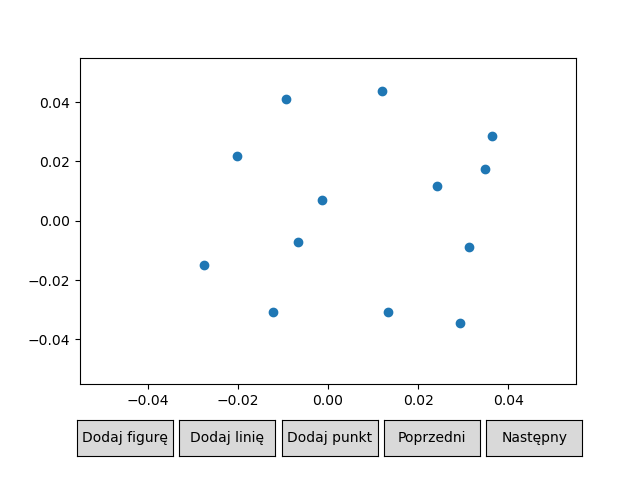

In [28]:
plot = Plot()
plot.draw()

<IPython.core.display.Javascript object>


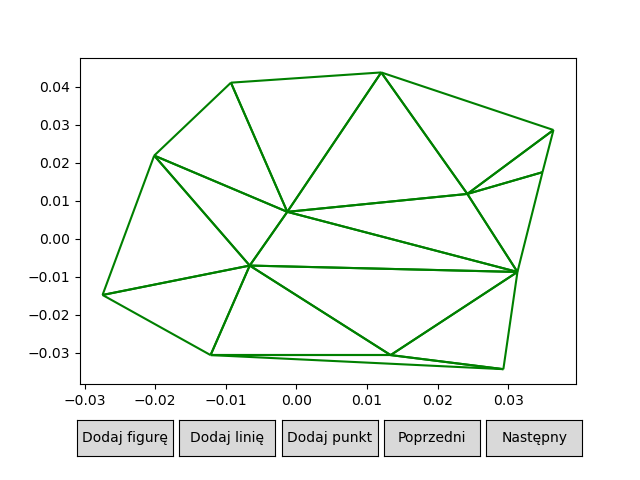

In [29]:
points = plot.get_added_elements().points[0].points
plotter = Plotter()
triangulation = delaunay_triangulation_with_visualization(sorted(points, key = lambda x : (x[1],x[0])), plotter)
plotter.draw()

<IPython.core.display.Javascript object>


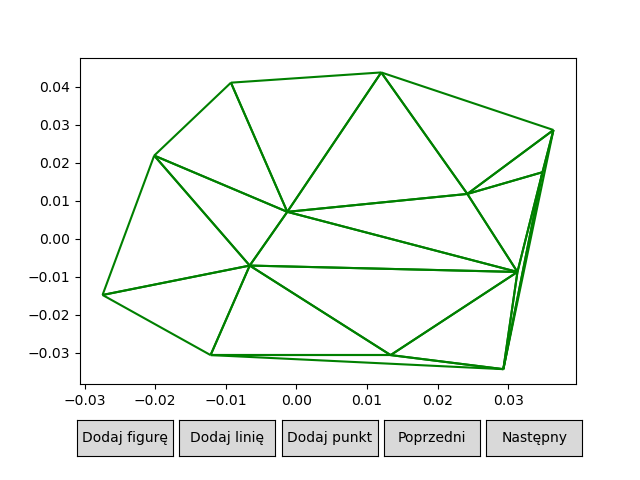

In [30]:
#points = plot.get_added_elements().points[0].points
plotter = Plotter()
triangulation = delaunay_triangulation(sorted(points, key = lambda x : (x[1],x[0])), plotter)
plotter.draw()

#### Generator losowych punktów 

In [31]:
from random import uniform
def generate_random_points(n):
    points = []
    for i in range(n):
        points.append((round(uniform(0,1),12),round(uniform(0,1),12)))
    return sorted(points, key = lambda x : (x[1],x[0]))

<IPython.core.display.Javascript object>


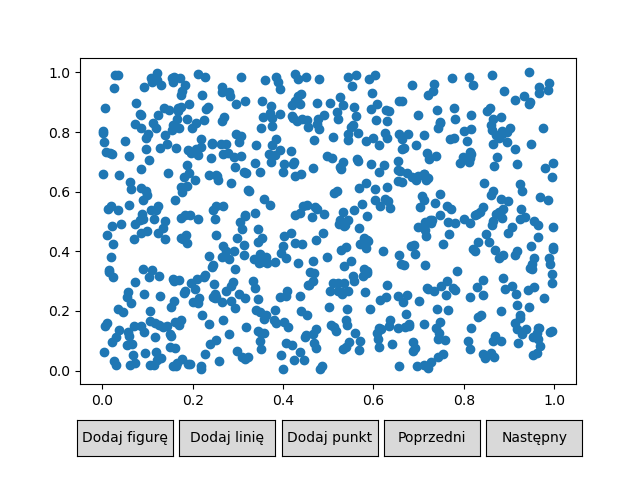

In [32]:
points2 = generate_random_points(750)
plot = Plot(scenes = [Scene(points = [PointsCollection(points2)])])
plot.draw()

<IPython.core.display.Javascript object>


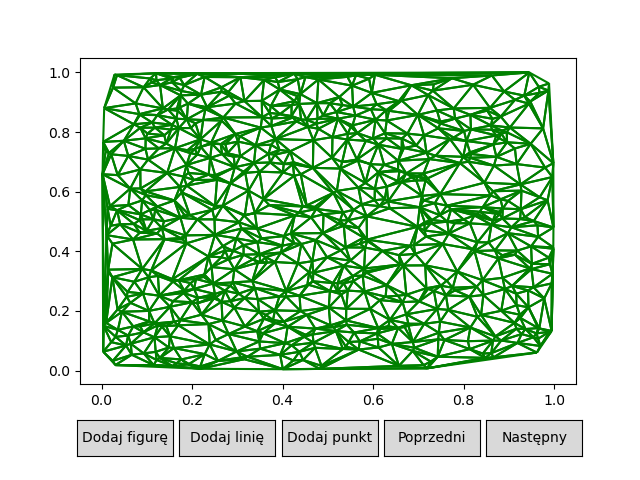

In [33]:
plotter = Plotter()
triangulation = delaunay_triangulation(sorted(points2, key = lambda x : (x[1],x[0])), plotter)
plotter.draw()

#### Funkcja mierzenia czasu

In [22]:
from time import time
def timing(func, points):
    start = time()
    func(points)
    end = time()
    
    print("Czas wykonania algorytmu: " + str(end-start) + "s")

In [89]:
timing(delaunay_triangulation, sorted(generate_random_points(750), key = lambda x : (x[1],x[0])))

Czas wykonania algorytmu: 0.8711106777191162s


In [90]:
timing(delaunay_triangulation, sorted(generate_random_points(1500), key = lambda x : (x[1],x[0])))

Czas wykonania algorytmu: 2.2985756397247314s


In [91]:
timing(delaunay_triangulation, sorted(generate_random_points(3000), key = lambda x : (x[1],x[0])))

Czas wykonania algorytmu: 6.4782586097717285s


In [95]:
timing(delaunay_triangulation, sorted(generate_random_points(6000), key = lambda x : (x[1],x[0])))

Czas wykonania algorytmu: 16.44454550743103s


In [115]:
timing(delaunay_triangulation, sorted(generate_random_points(12000), key = lambda x : (x[1],x[0])))

Czas wykonania algorytmu: 35.8920521736145s
